In [4]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

import os

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


In [5]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

In [14]:
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy > MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  5458k      0  0:00:01  0:00:01 --:--:-- 5455k


In [15]:
!mv MTA_Fare.npy $PUIDATA

In [27]:
mta = np.load('%s/MTA_Fare.npy'%os.getenv("PUIDATA"))

In [28]:
mta.shape

(600, 23, 194)

In [36]:
mta = mta.astype(float)

In [37]:
mta[mta==-1]=numpy.nan

In [40]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [41]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [272]:
date_range = pd.date_range(start='05/19/2010', end='02/19/2014',periods=194)

Text(0, 0.5, 'Swipes')

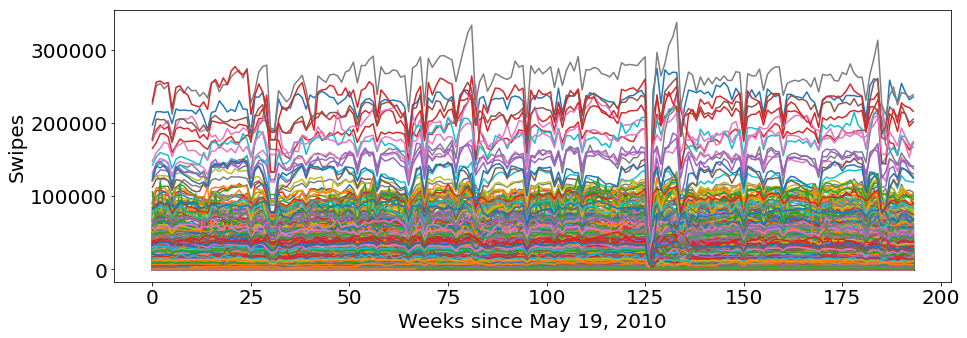

In [313]:
pl.figure(figsize=(15,5))

for i in range(mta.shape[0]):
    pl.plot(np.arange(len(date_range)), mta[i][:][:].transpose())
    
pl.xlabel('Weeks since May 19, 2010')
pl.ylabel('Swipes')

#### Figure 1. Time series for all ride types and subway stations from may 2010 to february 2014

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0, 0.5, 'Swipes')

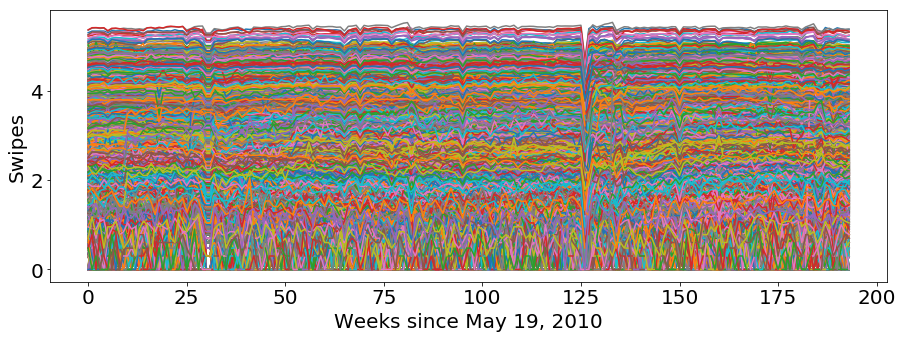

In [312]:
ticks = np.arange(0,200,step=25)
pl.figure(figsize=(15,5))

for i in range(mta.shape[0]):
    pl.plot(np.arange(len(date_range)), np.log10(mta[i][:][:]).transpose())

pl.xlabel('Weeks since May 19, 2010')
pl.ylabel('Swipes')

#### Figure 2. Time series for all ride types and subway stations from may 2010 to february 2014 in semi-log space

# 1: Event detection

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what may have caused this event

In [279]:
mta2 = mta.transpose(2,0,1).reshape(mta.shape[2],-1)

In [280]:
mta2.shape

(194, 13800)

In [281]:
np.nansum(mta2, axis=1).shape

(194,)

In [282]:
d = {'Date': date_range, 'Rides': np.nansum(mta2, axis=1)}

In [283]:
mta_pandas = pd.DataFrame(data=d)

In [284]:
mta_pandas.set_index('Date', inplace=True)

In [285]:
mta_pandas.head()

Rides
Date                                     
2010-05-19 00:00:00.000000000  26720267.0
2010-05-26 02:36:41.036269312  29265971.0
2010-06-02 05:13:22.072538880  29601189.0
2010-06-09 07:50:03.108808192  29387592.0
2010-06-16 10:26:44.145077760  29185768.0

Text(0, 0.5, 'rides')

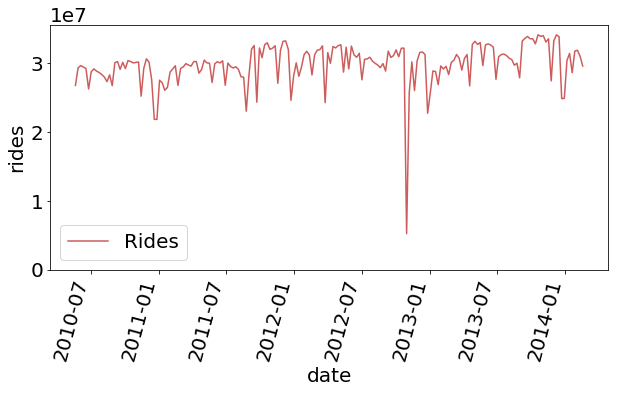

In [286]:
ax = mta_pandas.plot(figsize=(10,5), color="IndianRed")

pl.xticks(rotation=75, fontsize=20)
pl.yticks(fontsize=20)
pl.ylim(-20, pl.ylim()[1])
pl.legend(fontsize=20)
pl.xlabel("date", fontsize=20)
pl.ylabel("rides", fontsize=20)

#### Figure 3.

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


Text(0.5, 0, 'Date')

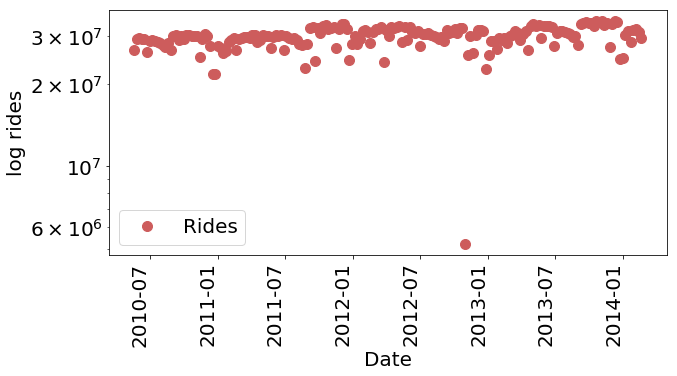

In [287]:

ax = mta_pandas.plot(logy=True, figsize=(10,5), style=".", ms=20, color="IndianRed")
pl.xticks(rotation=90, fontsize=20)

pl.yticks(fontsize=20)
pl.ylim(-20, pl.ylim()[1])
pl.legend(fontsize=20)
pl.ylabel("log rides", fontsize=20)
pl.xlabel("Date", fontsize=20)

#### Figure 4. 

# The mean and stardand deviation of the time series can be used to set a 3-sigma threshold

## every value that is more then 3 sigmas away from the mean can be flagged as an event

In [288]:
print ("mean rides by week {:.2f}".format(mta_pandas['Rides'].mean()))
print ("stdev rides by week {:.2f}".format(mta_pandas['Rides'].std()))
thresholds = [mta_pandas['Rides'].mean() + 3 * mta_pandas['Rides'].std(), 
              mta_pandas['Rides'].mean() - 3 * mta_pandas['Rides'].std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean rides by week 29781349.87
stdev rides by week 2991680.90
3-sigma thresholds 38756392.58 20806307.17


/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


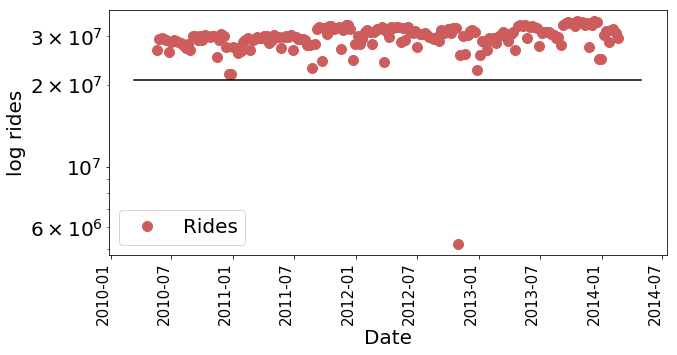

In [289]:
ax = mta_pandas.plot(logy=True, figsize=(10,5), style=".", ms=20, color="IndianRed")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k')
pl.xticks(rotation=90, fontsize=15)
pl.yticks(fontsize=20)
pl.ylim(-20, pl.ylim()[1])
pl.legend(fontsize=20)
pl.ylabel("log rides", fontsize=20)
pl.xlabel("Date", fontsize=20);

#### Figure 5. 

In [290]:
mta_pandas.loc[(mta_pandas.Rides < thresholds[1])]

Rides
Date                                    
2012-10-30 17:02:10.569948160  5218686.0

## The event that caused subway rides to drop so drastically in the week of October 30, 2012 was hurricane Sandy

# What other events are significant? We can remove 9/11 and look for more outliers - iterative thresholding

In [291]:
mta_pandas.loc[(mta_pandas.Rides < thresholds[1])] = np.nan

mean rides by week 29908617.56
stdev deaths by week 2416231.30
earliest datapoint 2010-05-19 00:00:00


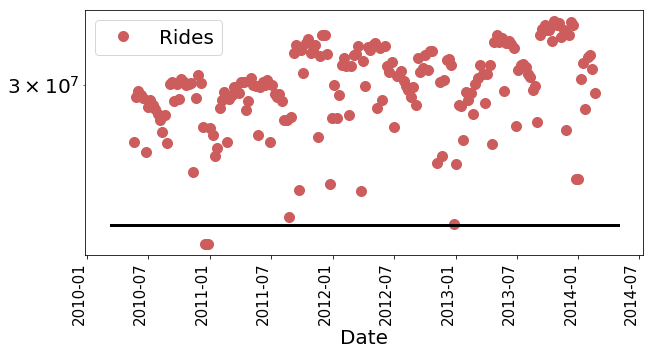

In [292]:
print ("mean rides by week {:.2f}".format(mta_pandas['Rides'].mean()))
print ("stdev deaths by week {:.2f}".format(mta_pandas['Rides'].std()))
thresholds = [mta_pandas['Rides'].mean() + 3 * mta_pandas['Rides'].std(), 
              mta_pandas['Rides'].mean() - 3 * mta_pandas['Rides'].std()]
print ("earliest datapoint", min(mta_pandas.index))
ax = mta_pandas.plot(logy=True, figsize=(10,5), style=".", ms=20, color="IndianRed")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color="Black", lw=3)
pl.xticks(rotation=90, fontsize=15);

#### Figure 6. 

In [293]:
mta_pandas.loc[(mta_pandas.Rides < thresholds[1])]

Rides
Date                                     
2010-12-18 06:20:31.088082944  21802973.0
2010-12-25 08:57:12.124352256  21796368.0

## In December 2010, there was a big blizzard where subway stations had to close

# 2: finding trends

In [294]:
mta_ridetypes = np.nanmean(mta, axis=0)

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [295]:
mta_ridetypes.shape

(23, 194)

In [296]:
mta_ridetypes_pandas = pd.DataFrame(data=mta_ridetypes.transpose(),index=date_range,columns=ridetype) 

In [297]:
mta_ridetypes_pandas.head()

10t          14d          1d  \
2010-05-19 00:00:00.000000000  24880.119048  1148.320346  103.465368   
2010-05-26 02:36:41.036269312  27173.229935  1265.798265  111.683297   
2010-06-02 05:13:22.072538880  27573.708423  1266.077754  111.524838   
2010-06-09 07:50:03.108808192  27329.751620  1215.123110  112.447084   
2010-06-16 10:26:44.145077760  27607.099138  1182.883621  110.243534   

                                       2t         30d           7d  \
2010-05-19 00:00:00.000000000  403.790043  101.316017  8003.123377   
2010-05-26 02:36:41.036269312  432.167028  139.594360  8637.327549   
2010-06-02 05:13:22.072538880  431.248380  123.097192  8710.647948   
2010-06-09 07:50:03.108808192  424.166307   80.840173  8710.049676   
2010-06-16 10:26:44.145077760  420.006466   75.883621  8460.012931   

                                        ada       afas         exp  \
2010-05-19 00:00:00.000000000  18510.686147  21.781385  721.205628   
2010-05-26 02:36:41.036269312  20577.861171  25.698482  613.351410   
2010-06-02 05:13:22.072538880  20467.684665  26.516199  652.328294   
2010-06-09 07:50:03.108808192  20410.542117  24.235421  659.855292   
2010-06-16 10:26:44.145077760  20030.176724  22.661638  723.663793   

                                        ez  ...        month          rfm  \
2010-05-19 00:00:00.000000000  1108.294372  ...   266.523810  1710.194805   
2010-05-26 02:36:41.036269312  1253.845987  ...   329.605206  1969.778742   
2010-06-02 05:13:22.072538880  1329.453564  ...   327.295896  1974.349892   
2010-06-09 07:50:03.108808192  1309.438445  ...   317.697624  1949.349892   
2010-06-16 10:26:44.145077760  1214.323276  ...   297.172414  1843.907328   

                                       rr        sen     spec        tcmc  \
2010-05-19 00:00:00.000000000  129.456710  61.084416  0.00000  269.898268   
2010-05-26 02:36:41.036269312  150.127983  70.136659  0.00000  264.019523   
2010-06-02 05:13:22.072538880  150.267819  70.449244  0.00000  263.889849   
2010-06-09 07:50:03.108808192  147.082073  69.987041  0.00000  263.609071   
2010-06-16 10:26:44.145077760  143.053879  68.821121  0.37931  258.137931   

                                       t      umlim      xbus  stud  
2010-05-19 00:00:00.000000000  45.584416  13.264069  0.774892   NaN  
2010-05-26 02:36:41.036269312  47.006508  13.275488  1.028200   NaN  
2010-06-02 05:13:22.072538880  46.291577  14.017279  1.004320   NaN  
2010-06-09 07:50:03.108808192  46.717063  14.233261  1.045356   NaN  
2010-06-16 10:26:44.145077760  43.743534  13.605603  0.974138   NaN  

[5 rows x 23 columns]

In [302]:
mta_ridetype_mean = mta_ridetypes_pandas.rolling(10).mean()

In [303]:
mta_ridetype_std = mta_ridetypes_pandas.rolling(10).std()

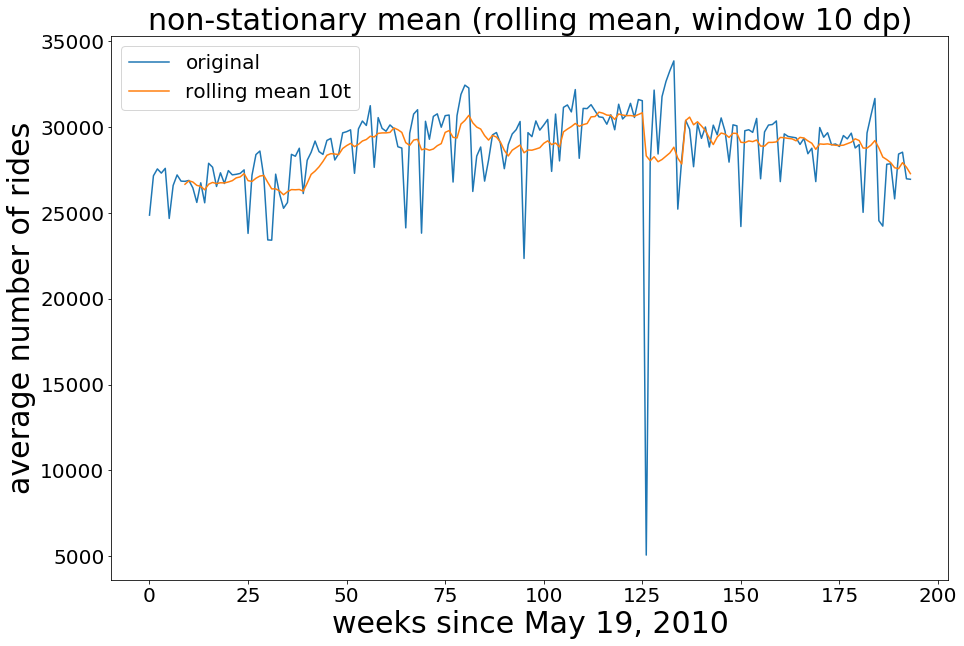

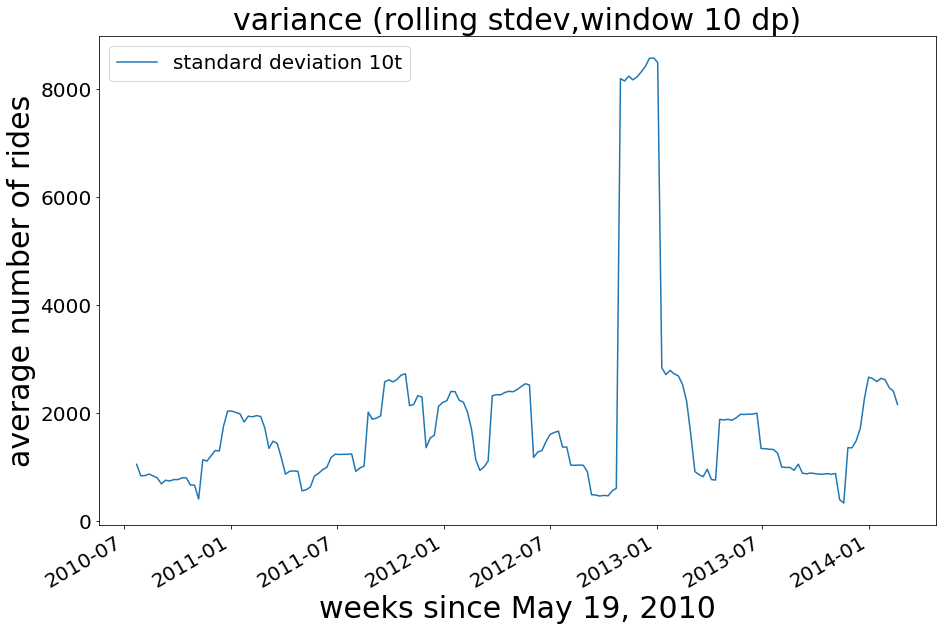

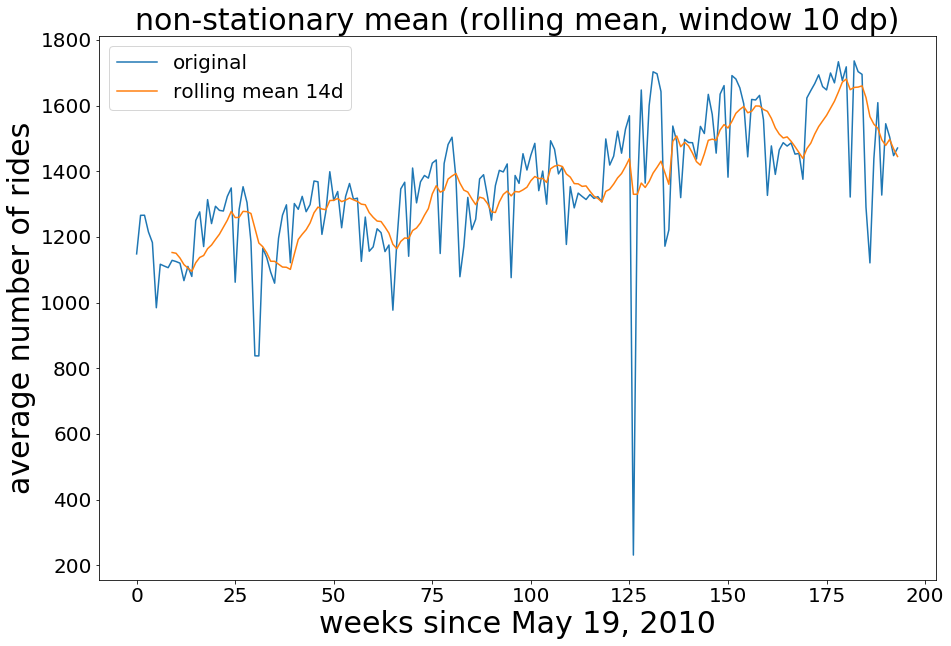

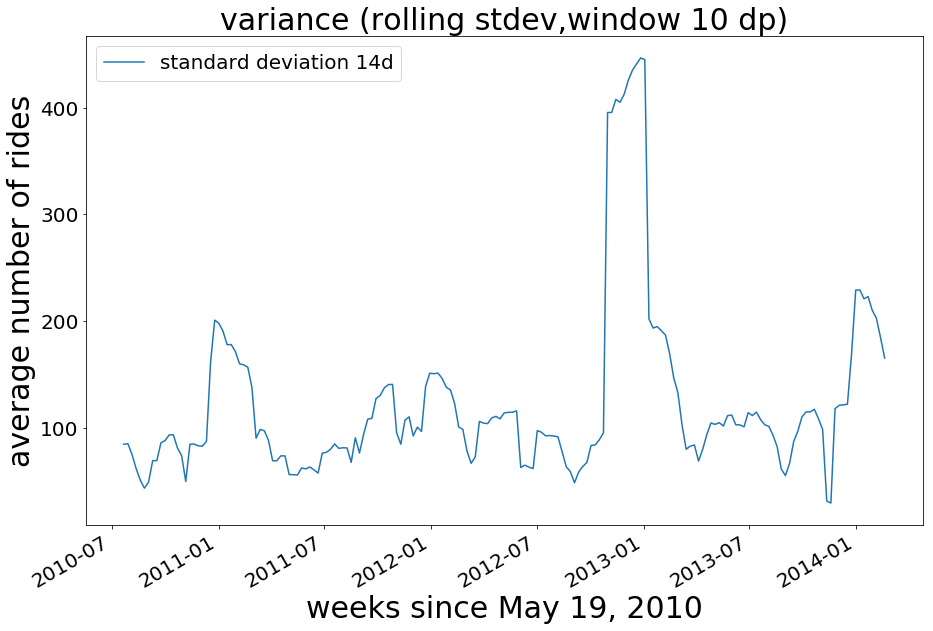

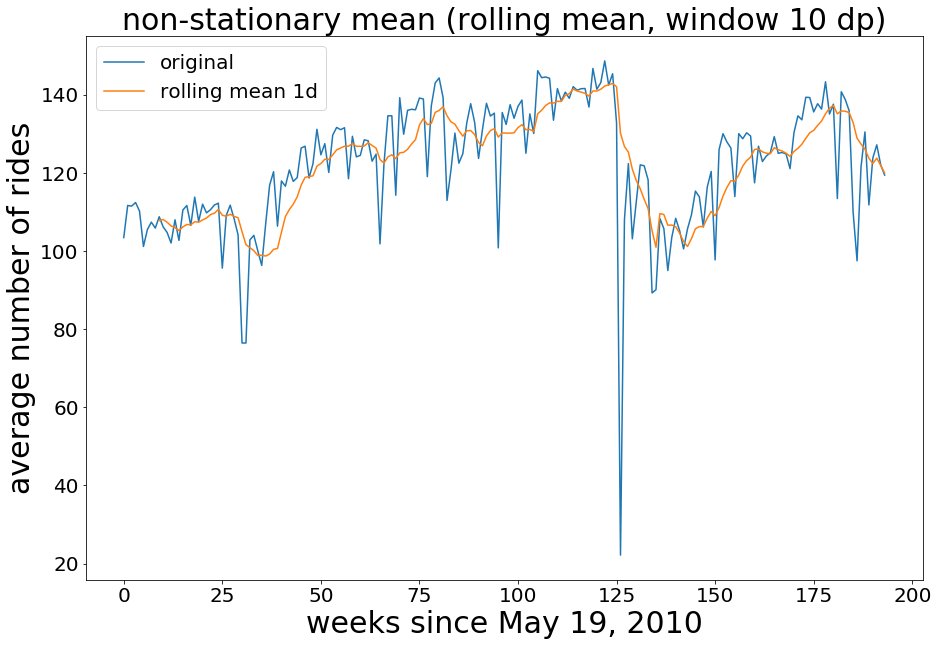

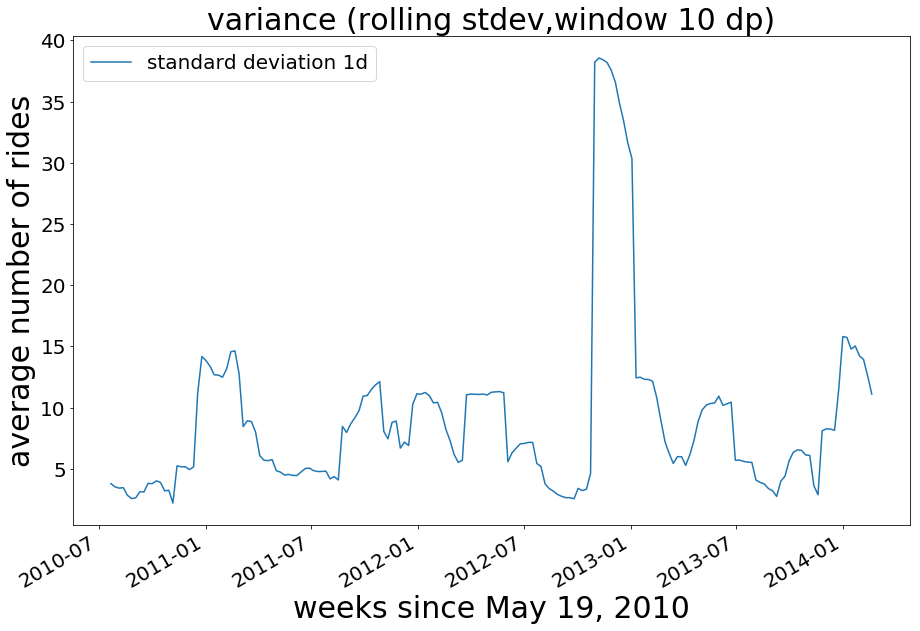

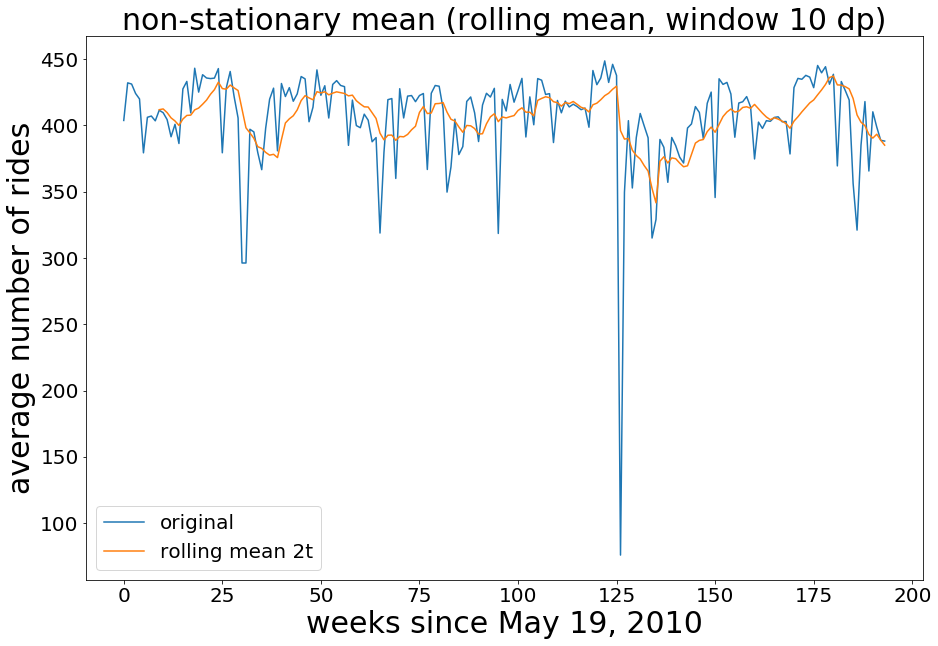

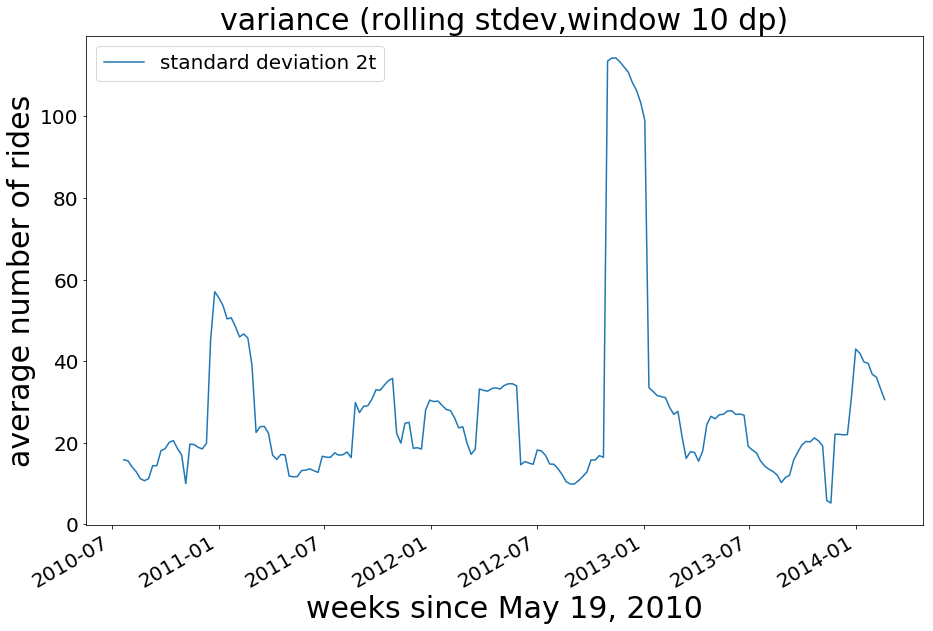

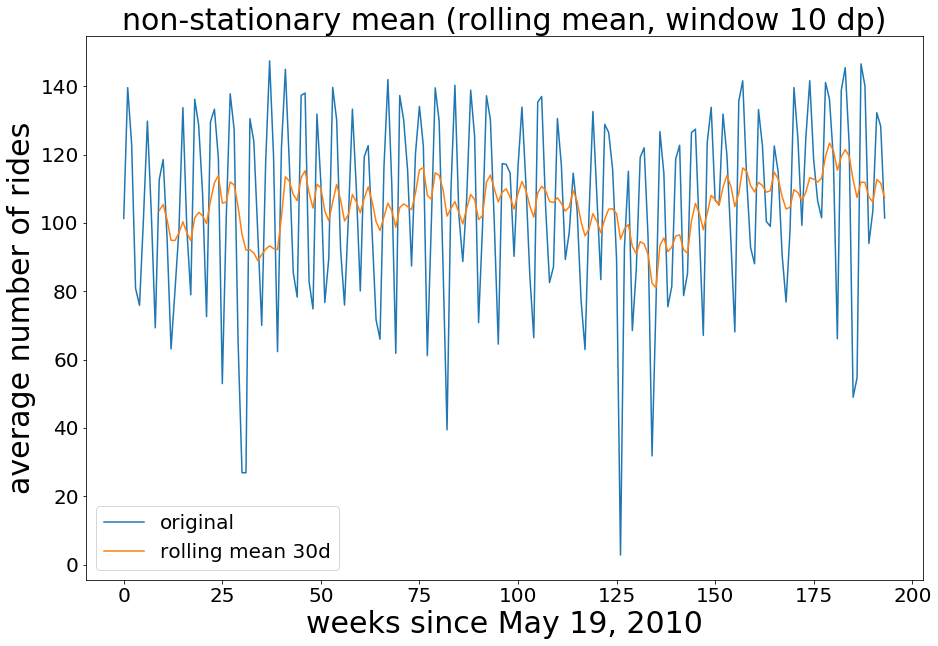

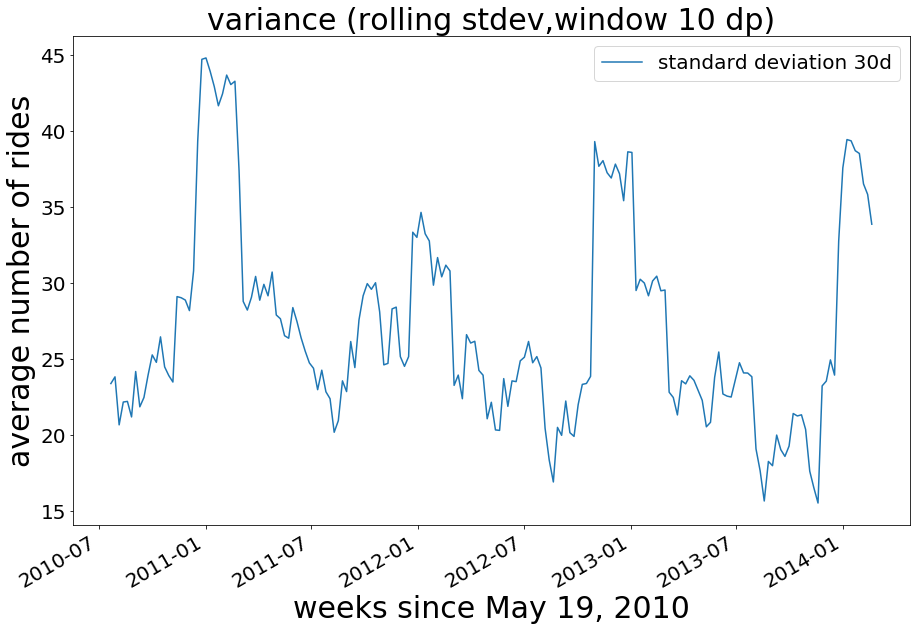

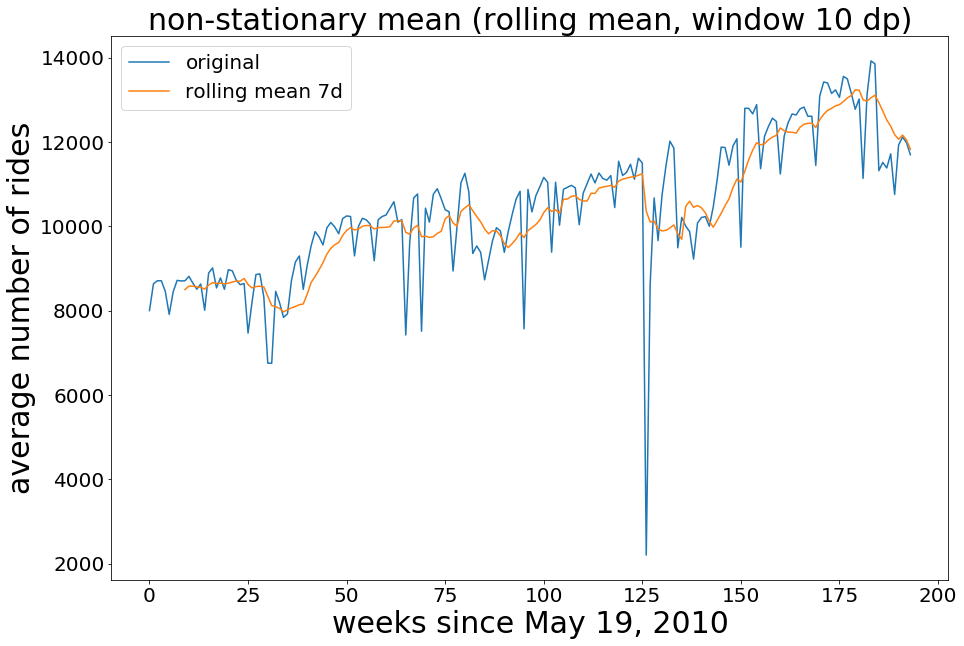

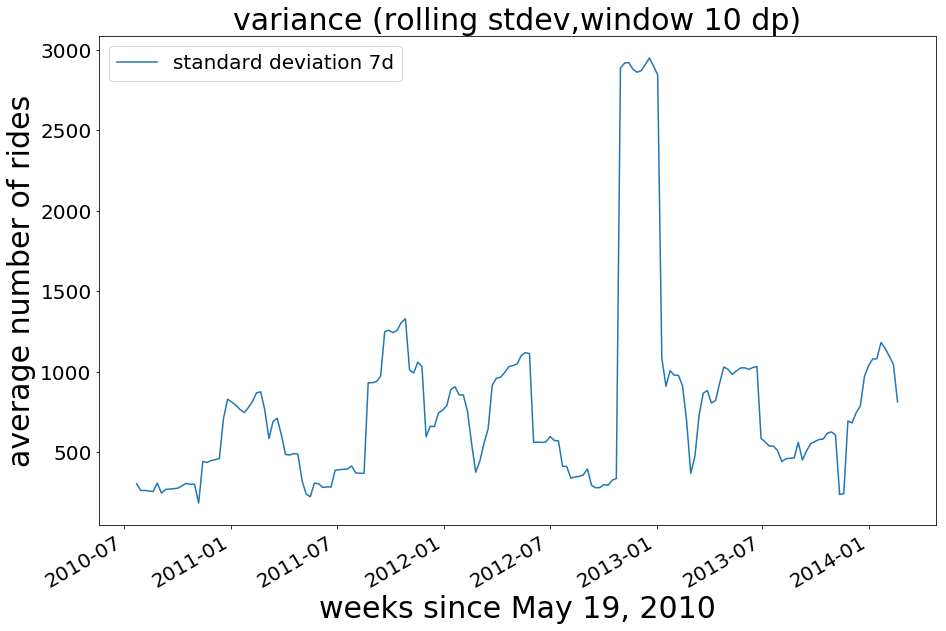

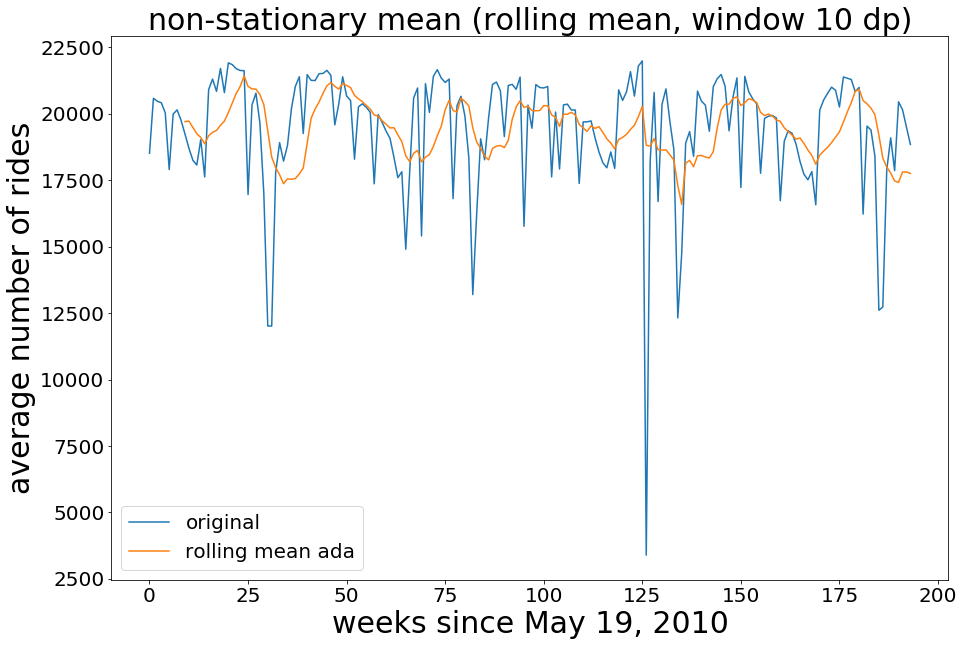

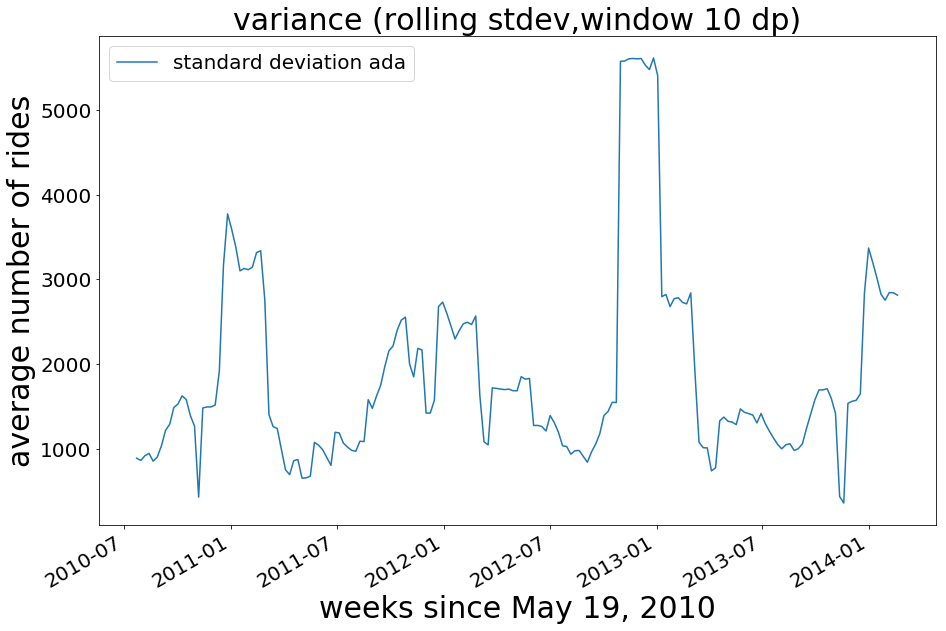

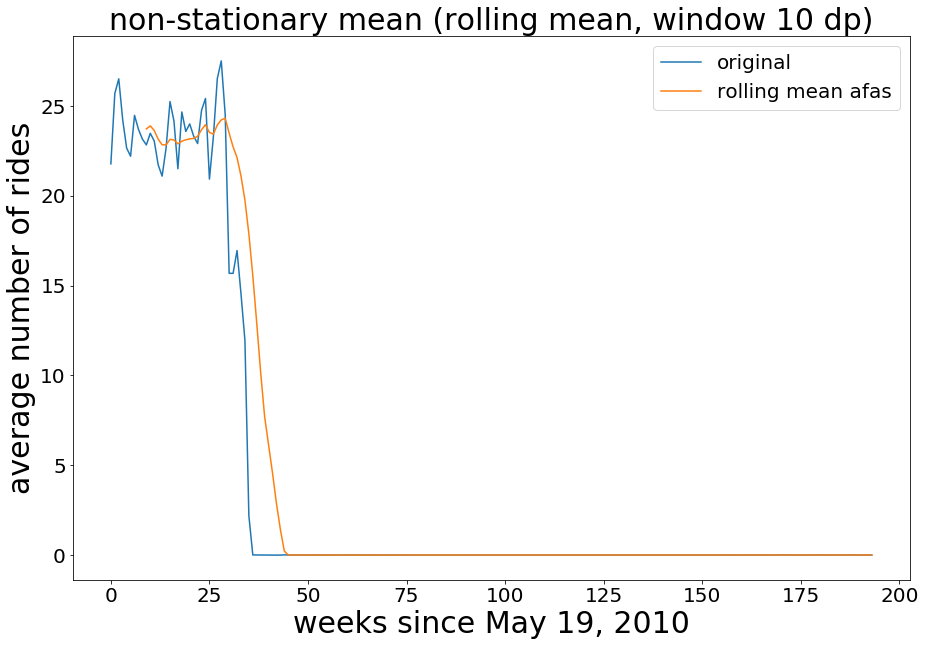

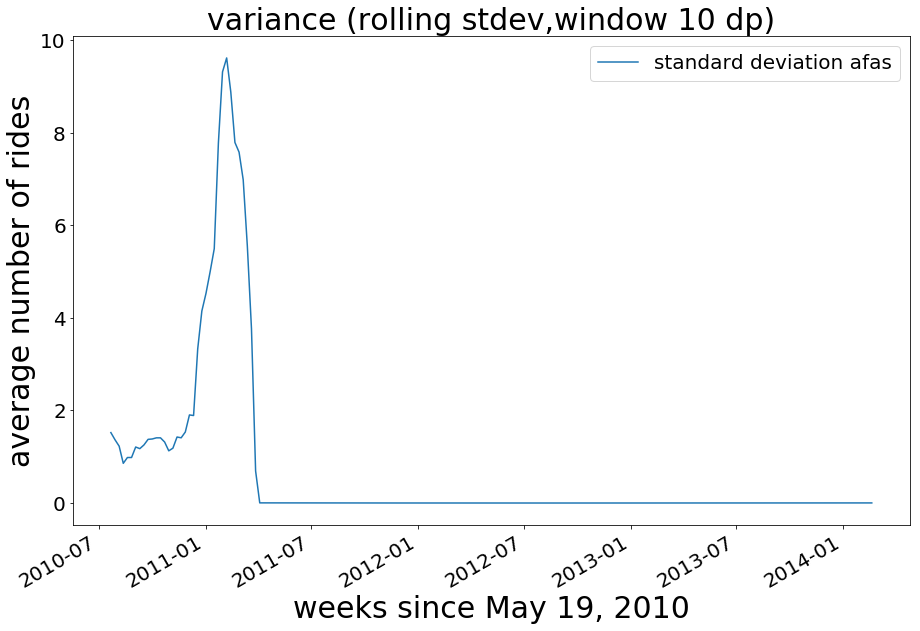

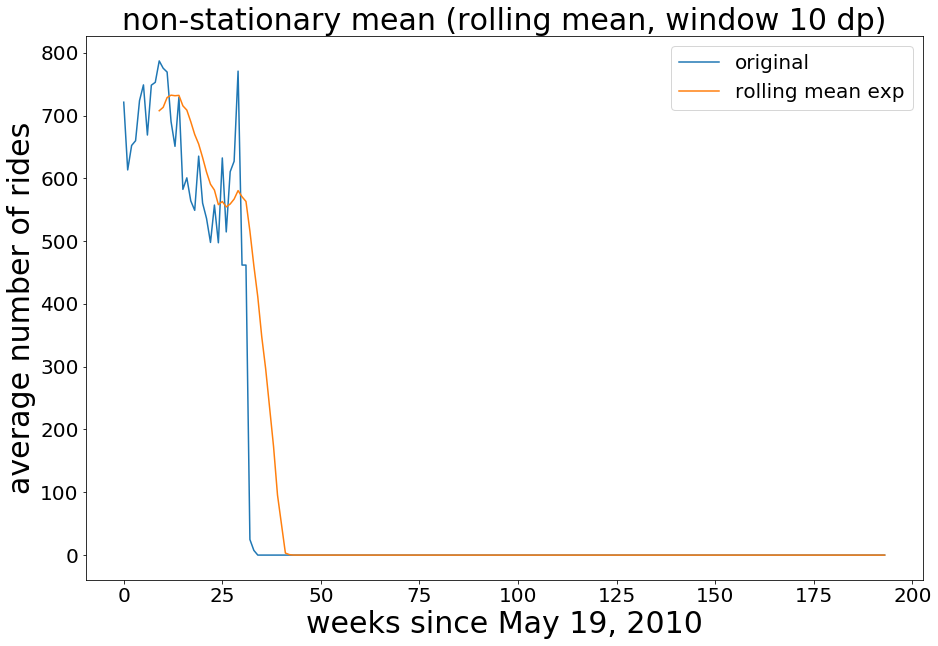

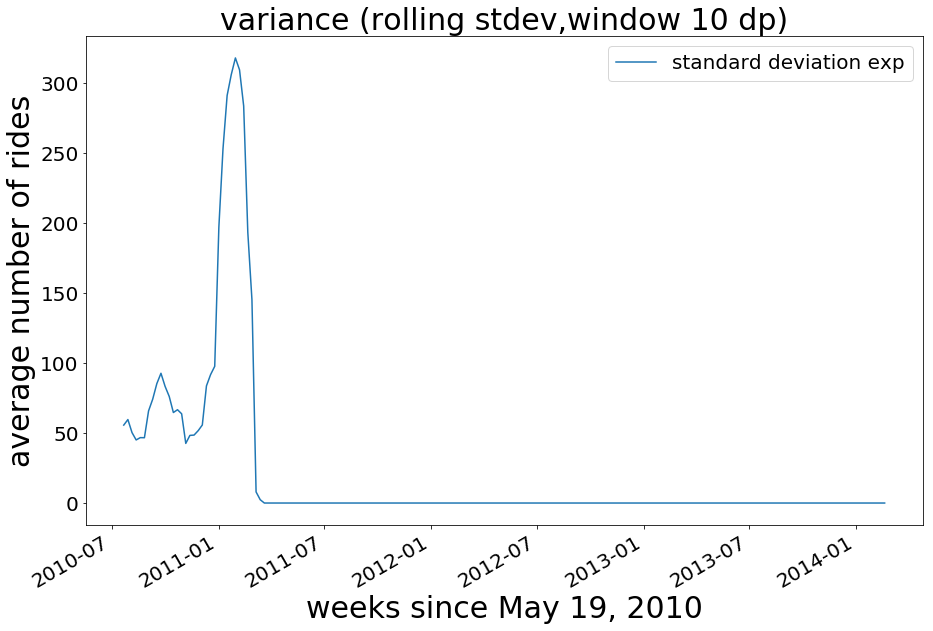

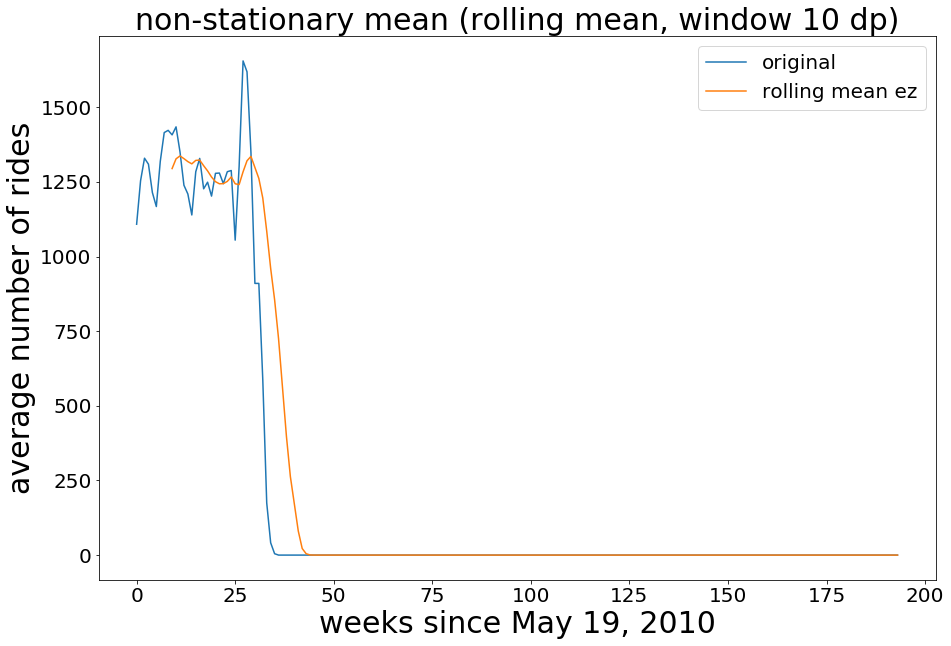

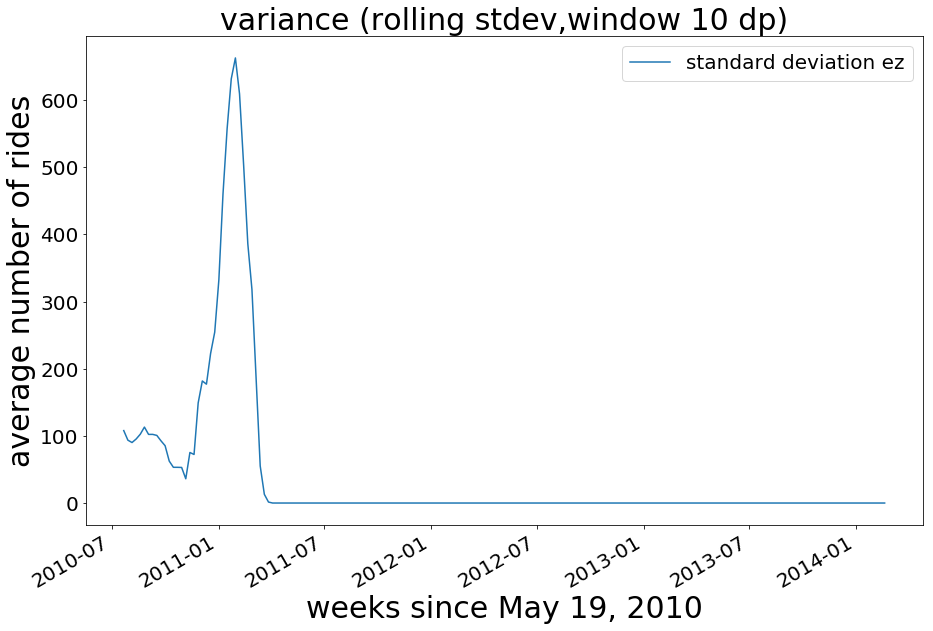

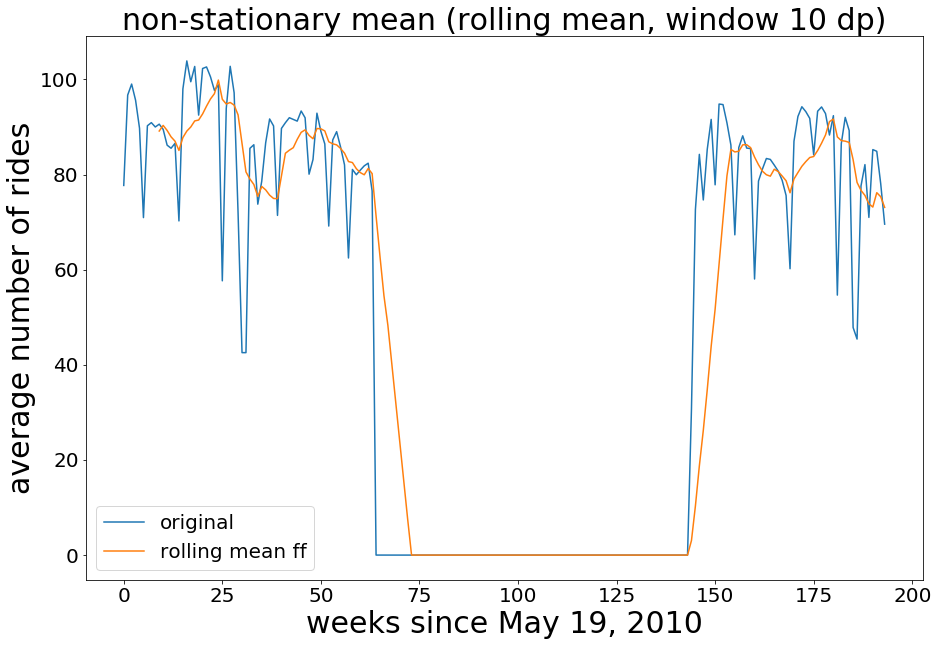

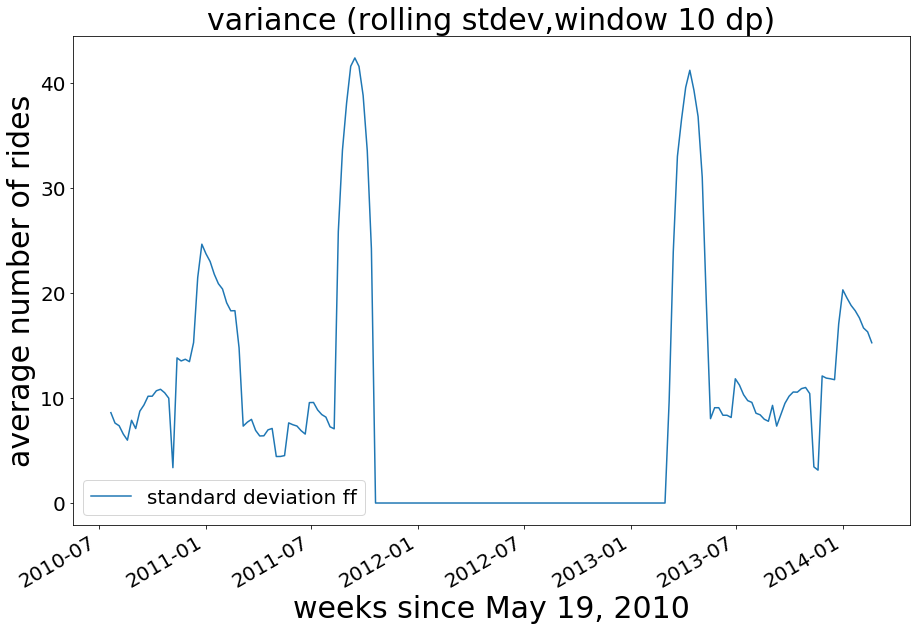

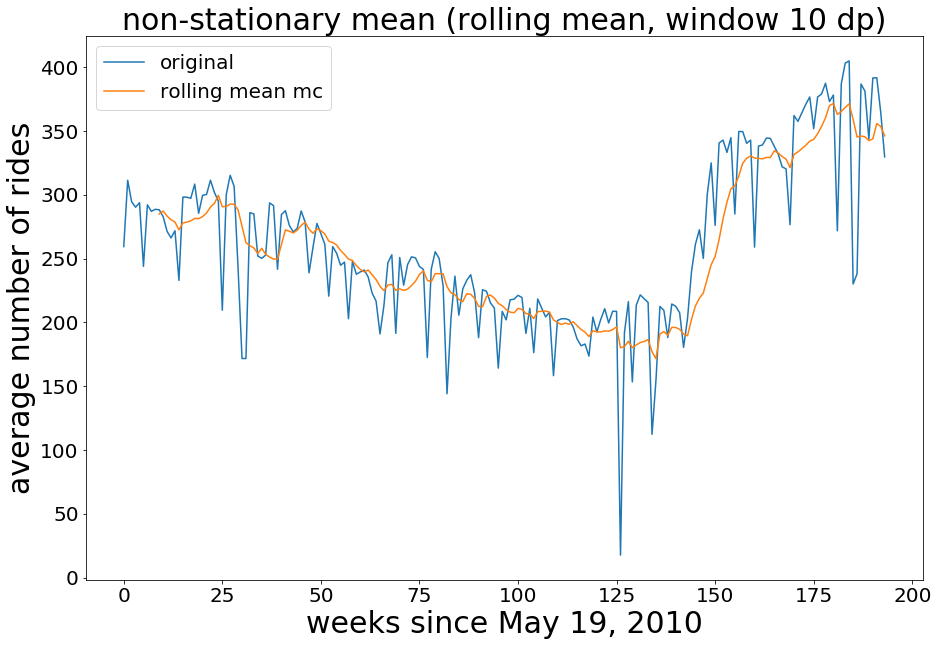

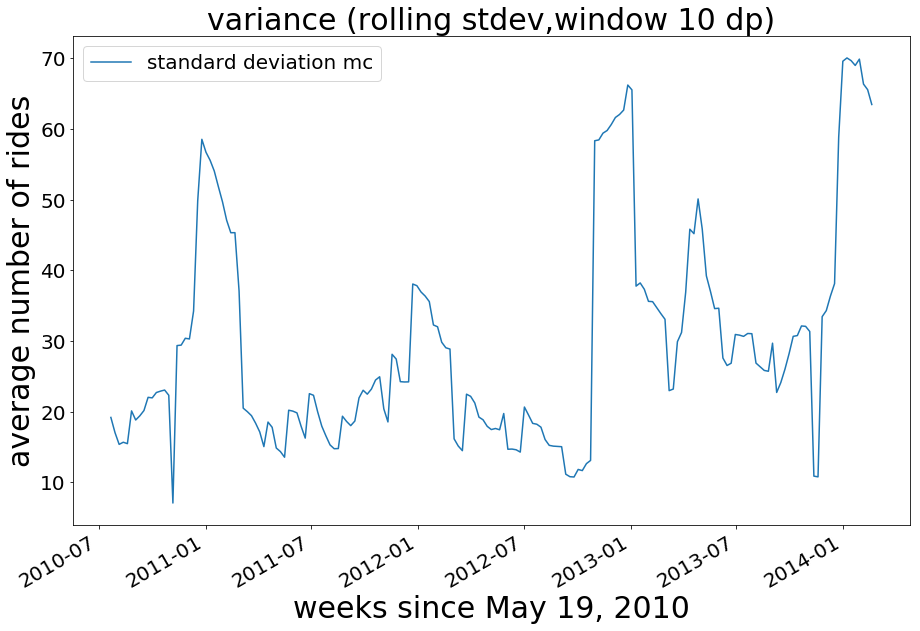

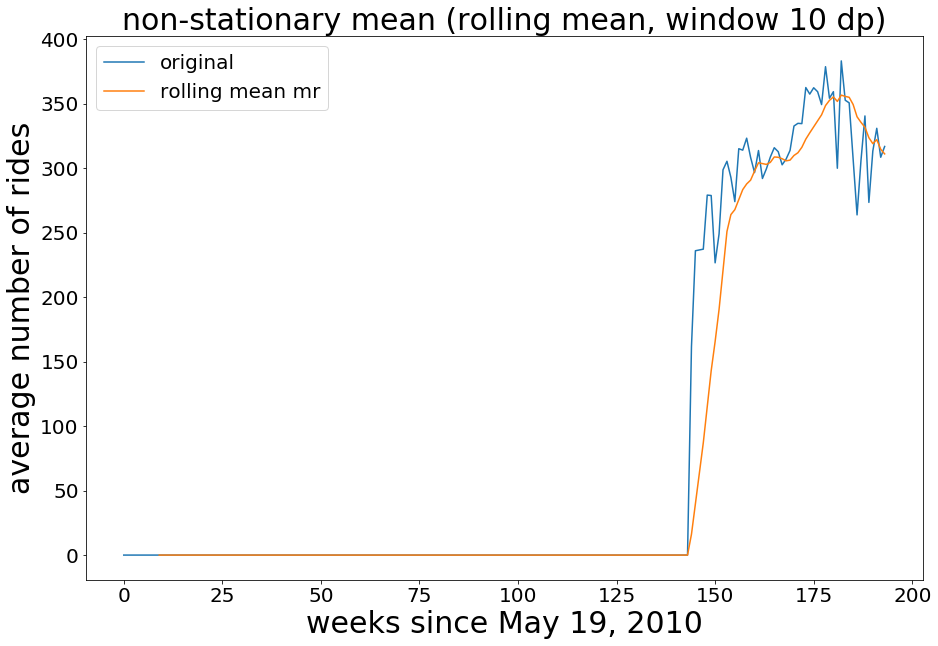

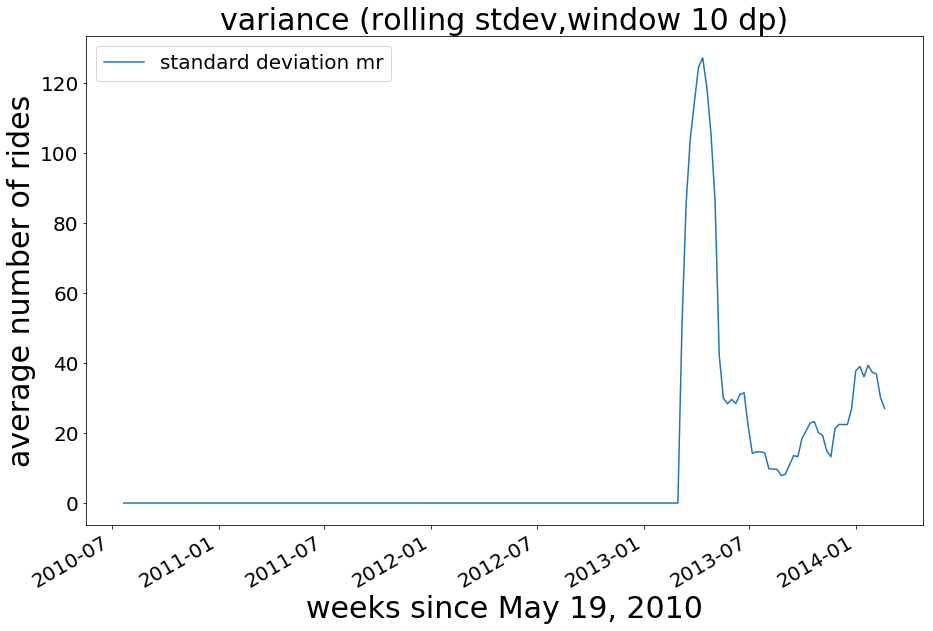

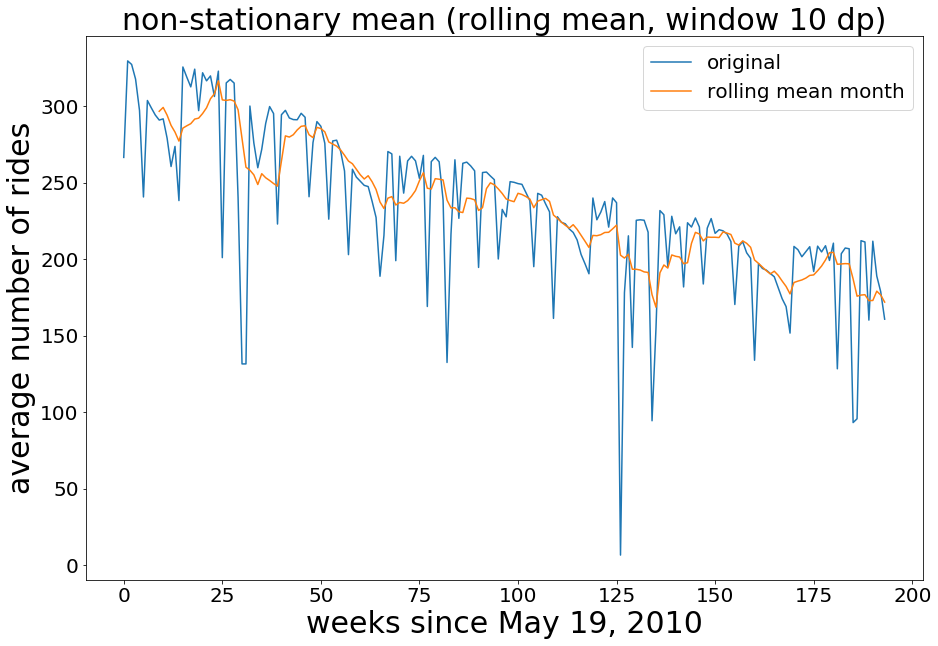

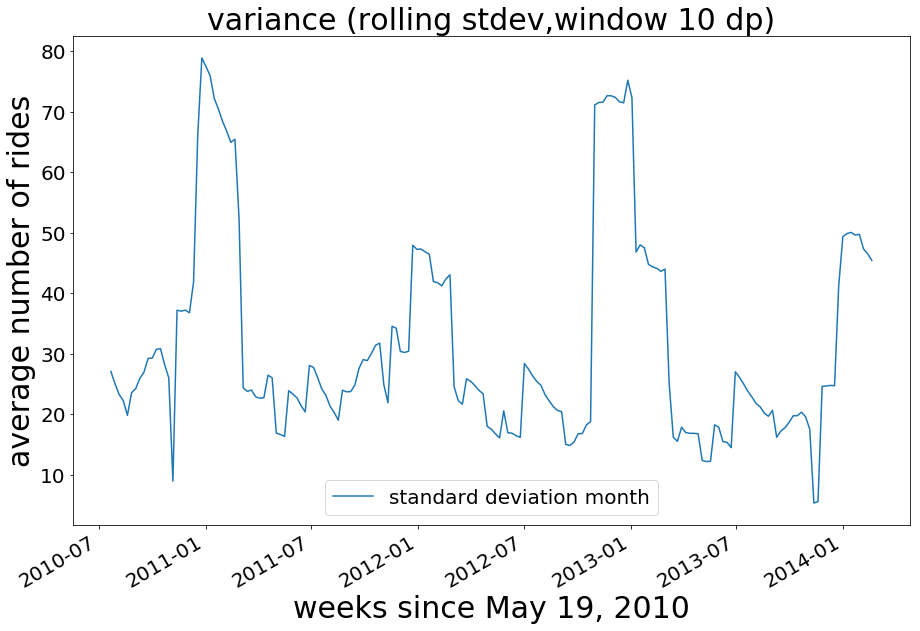

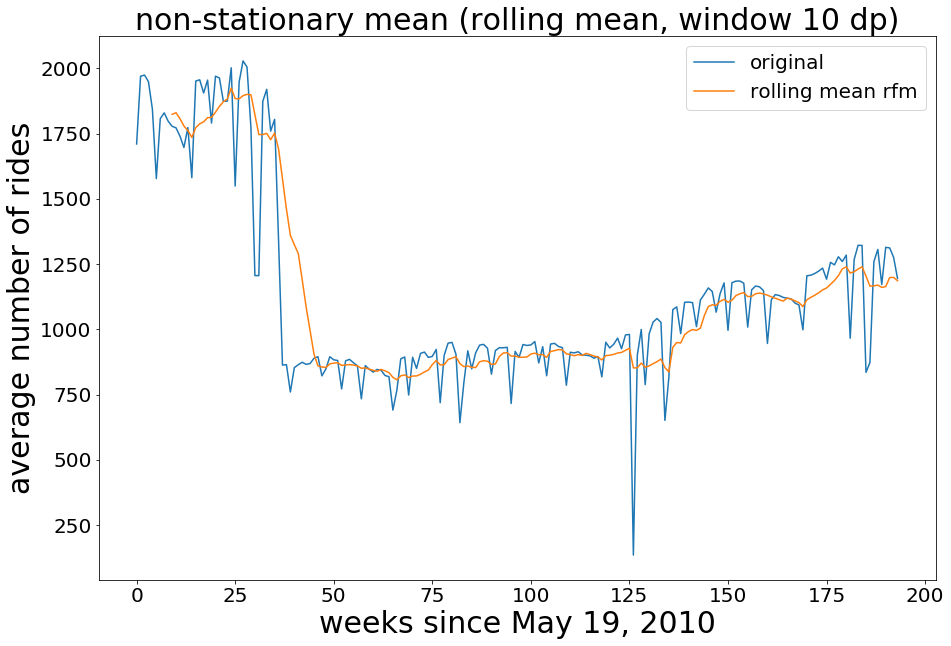

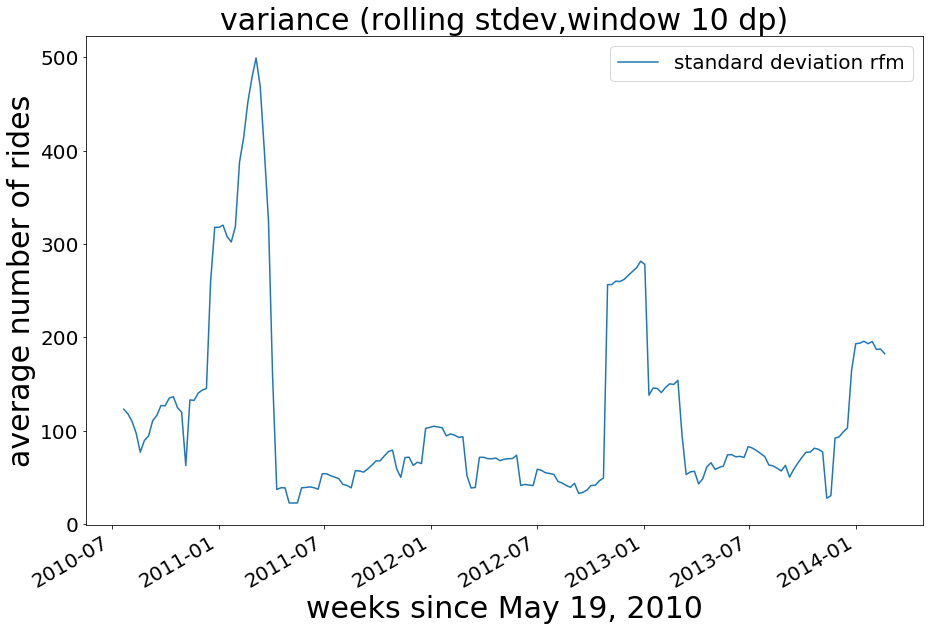

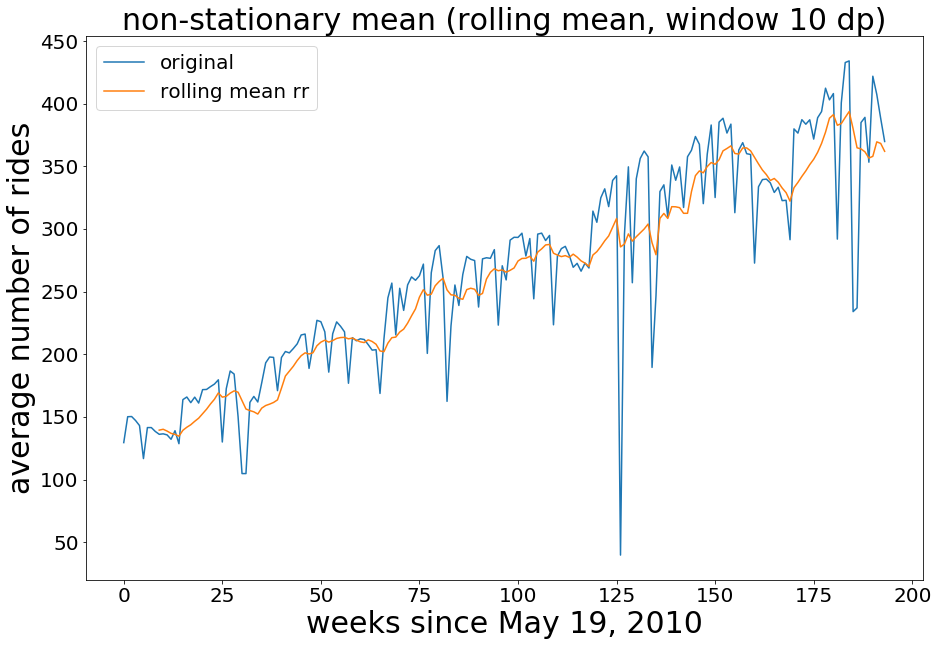

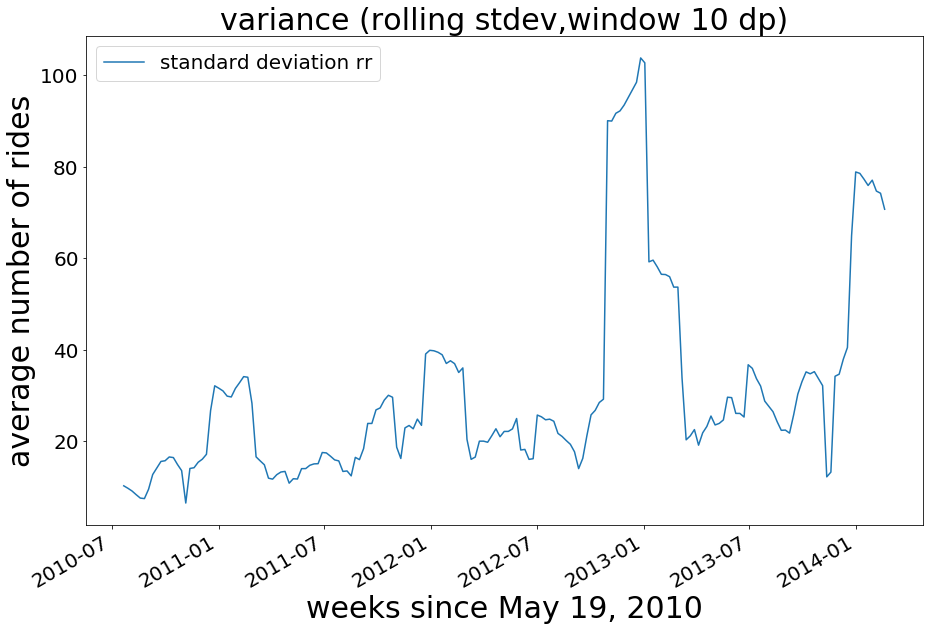

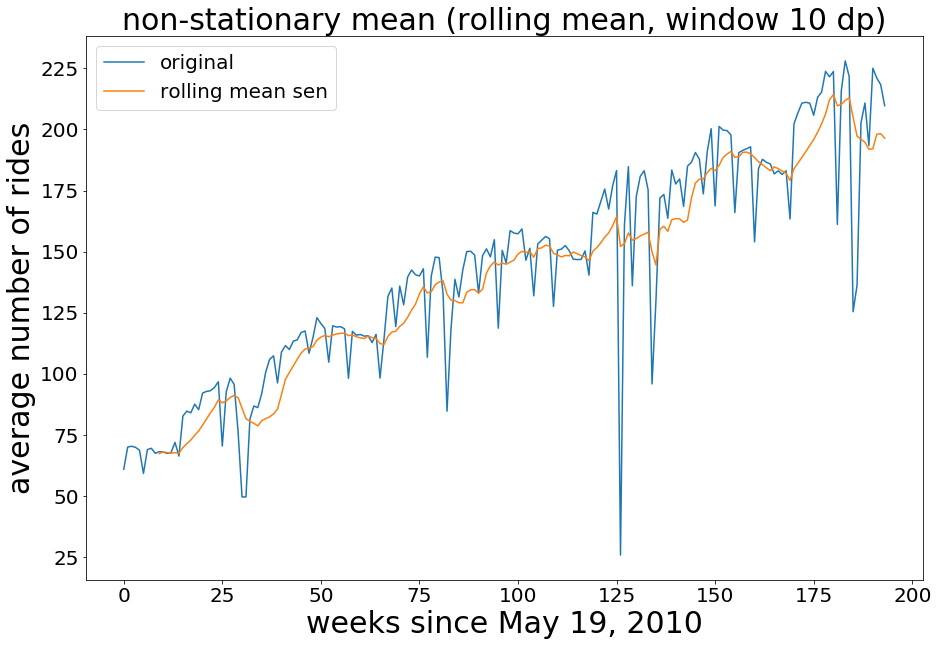

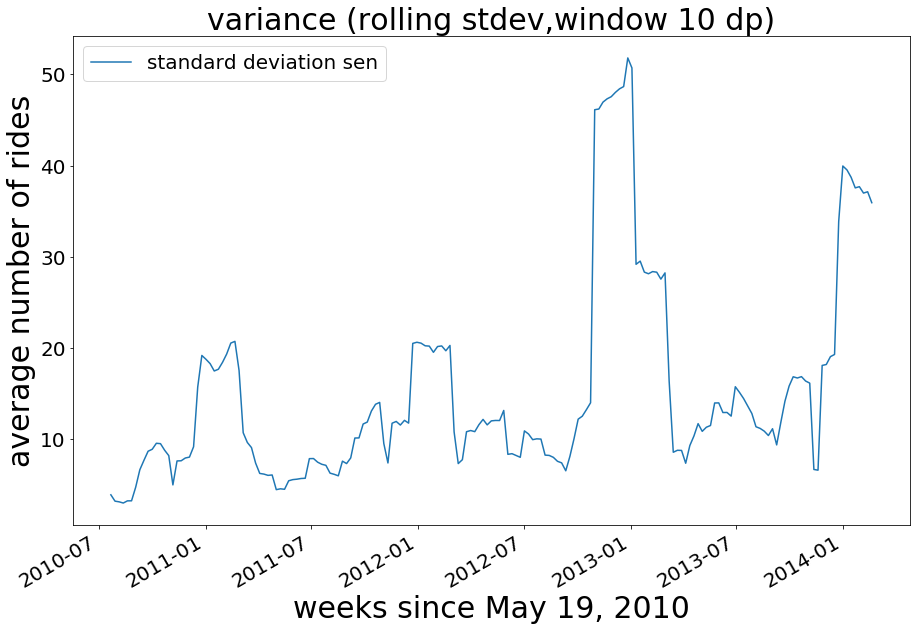

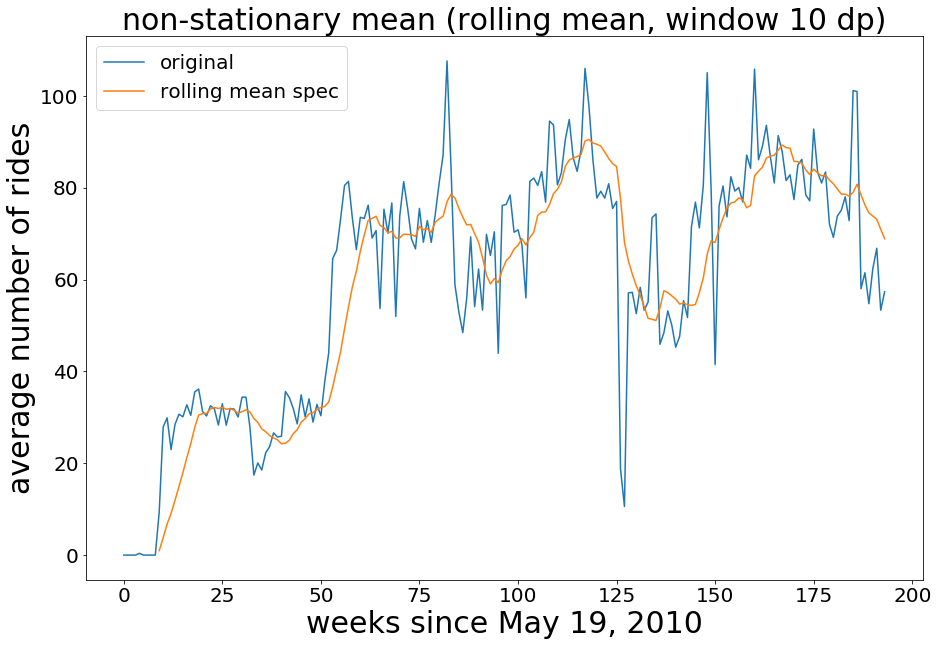

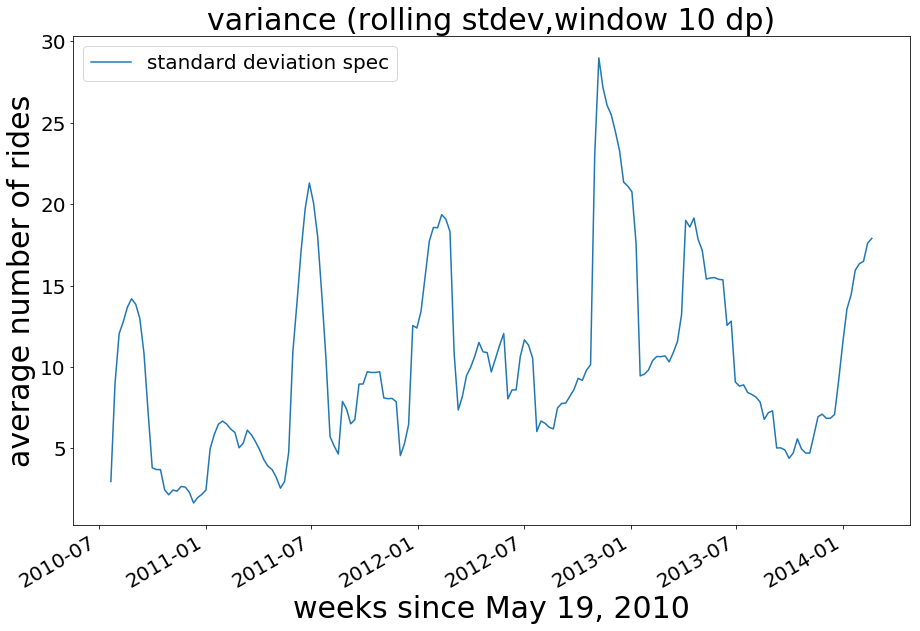

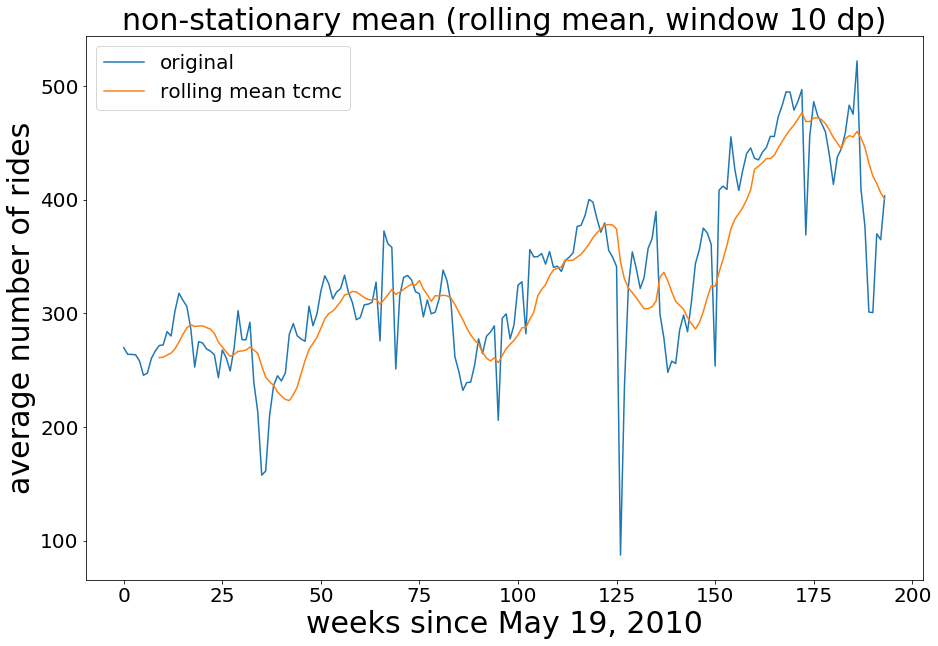

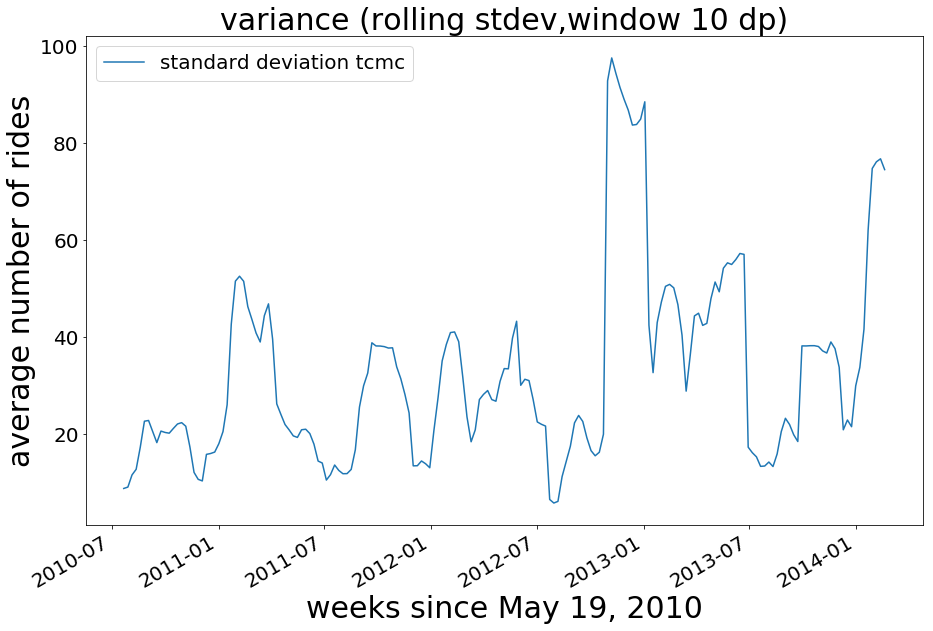

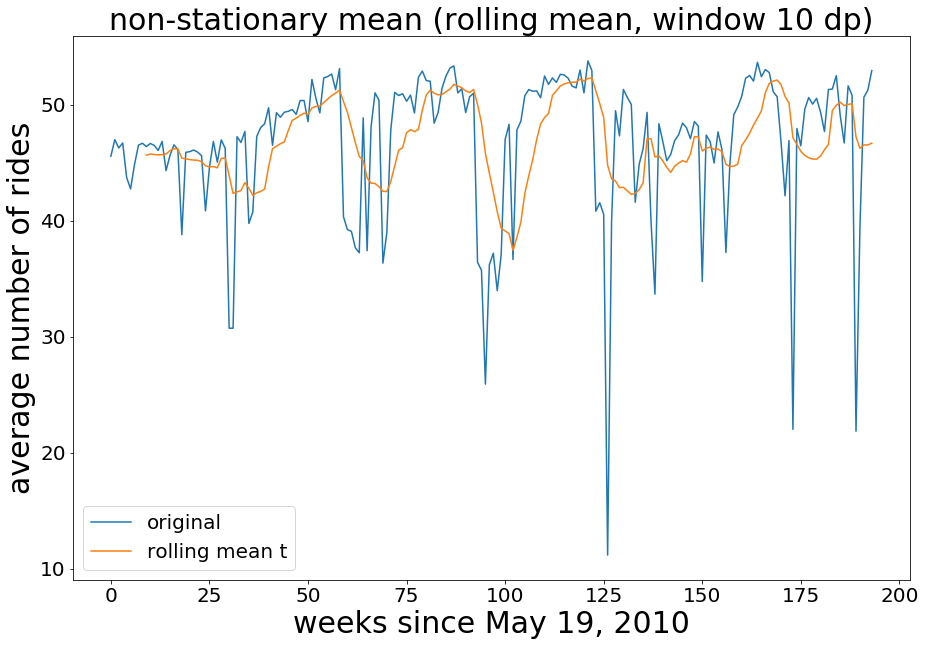

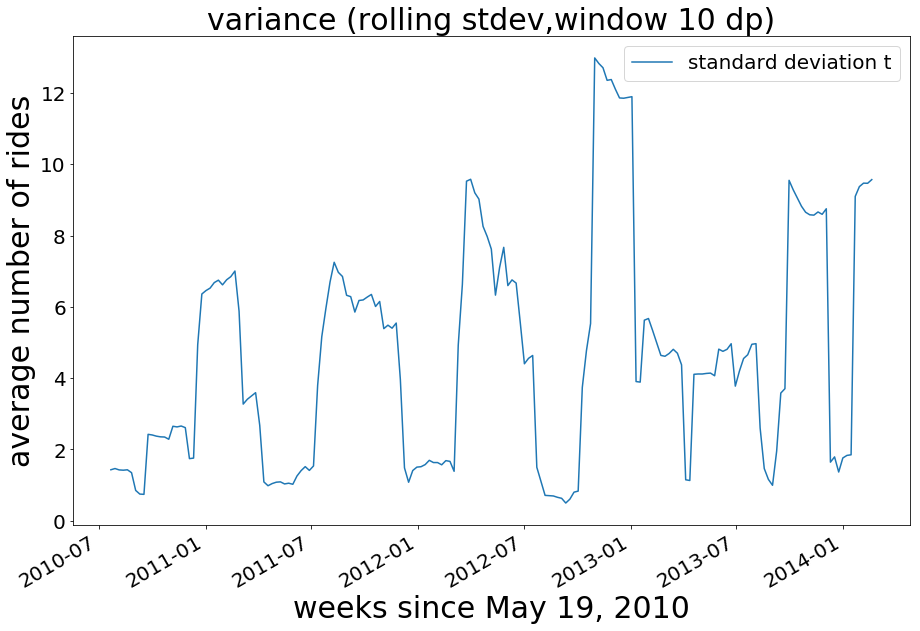

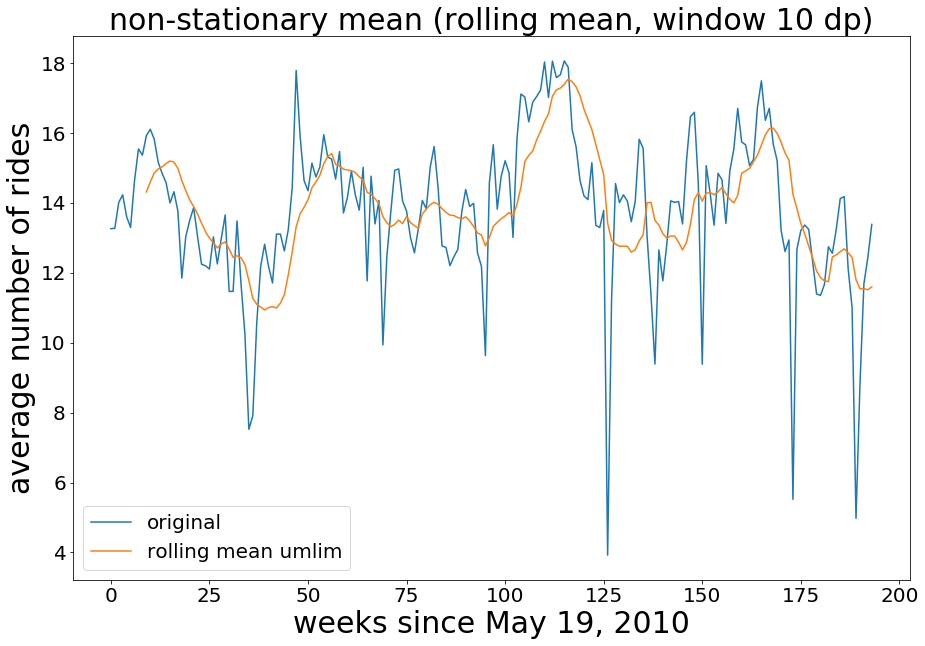

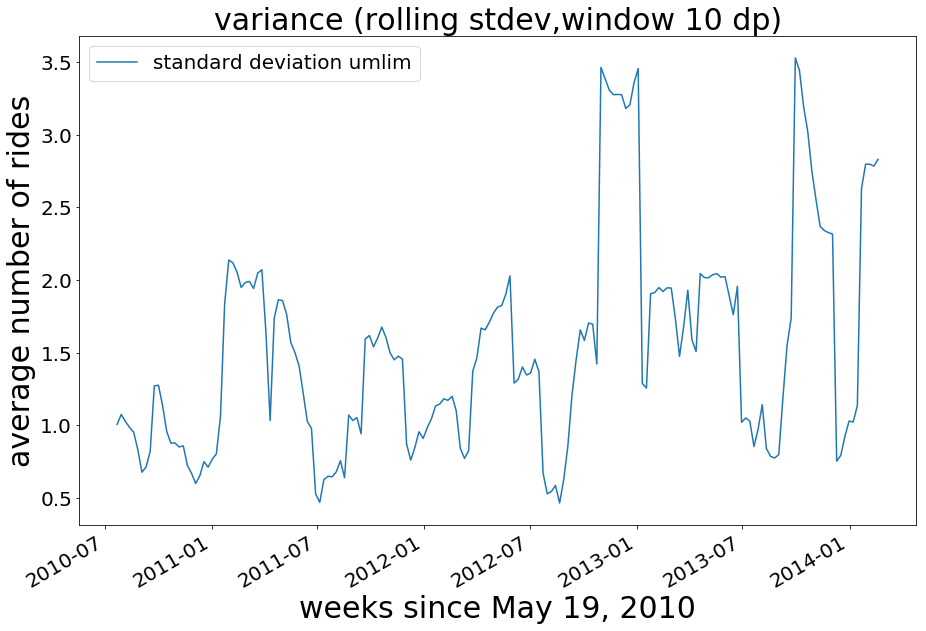

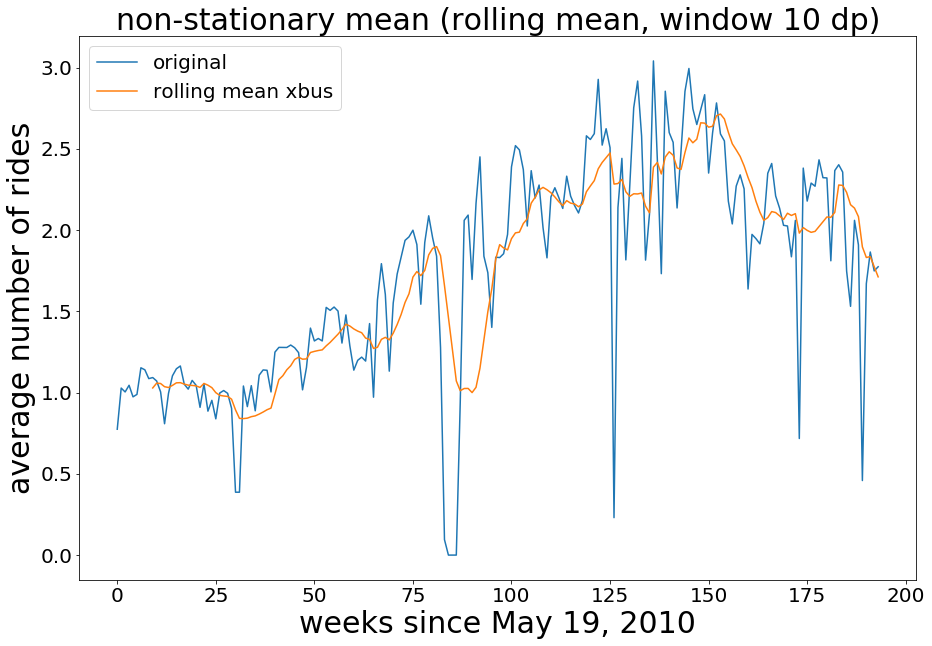

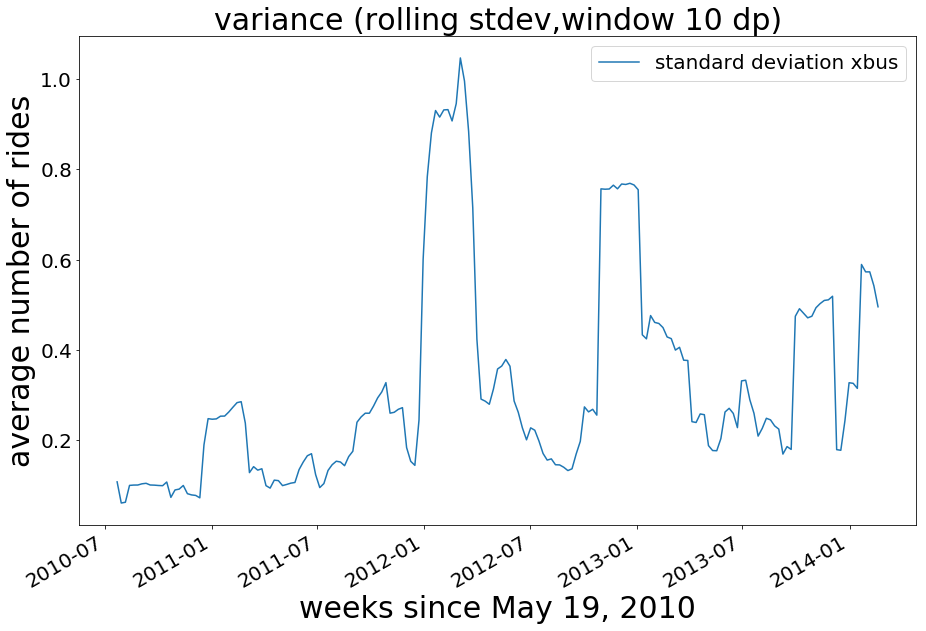

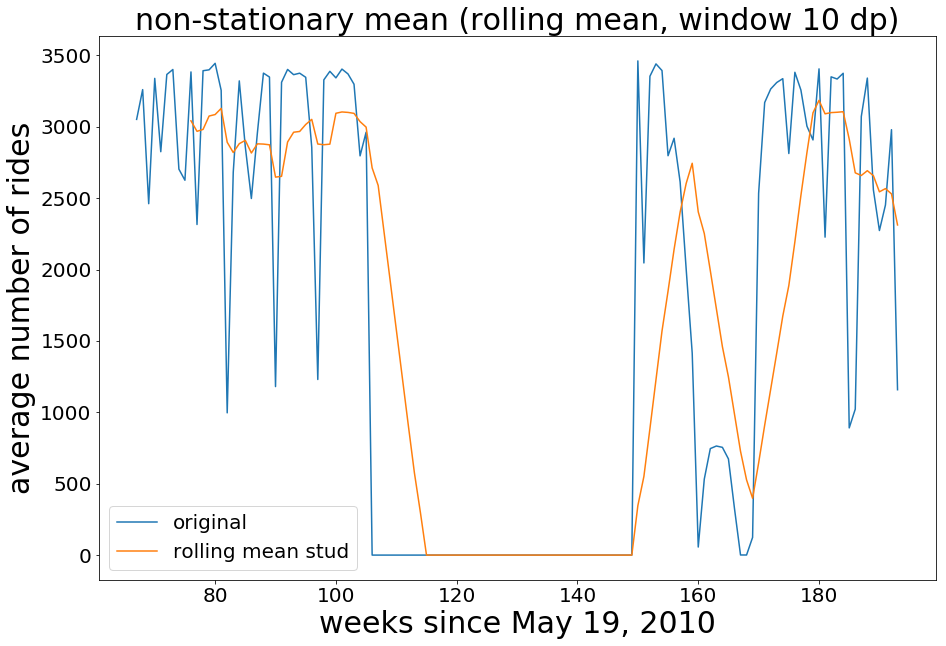

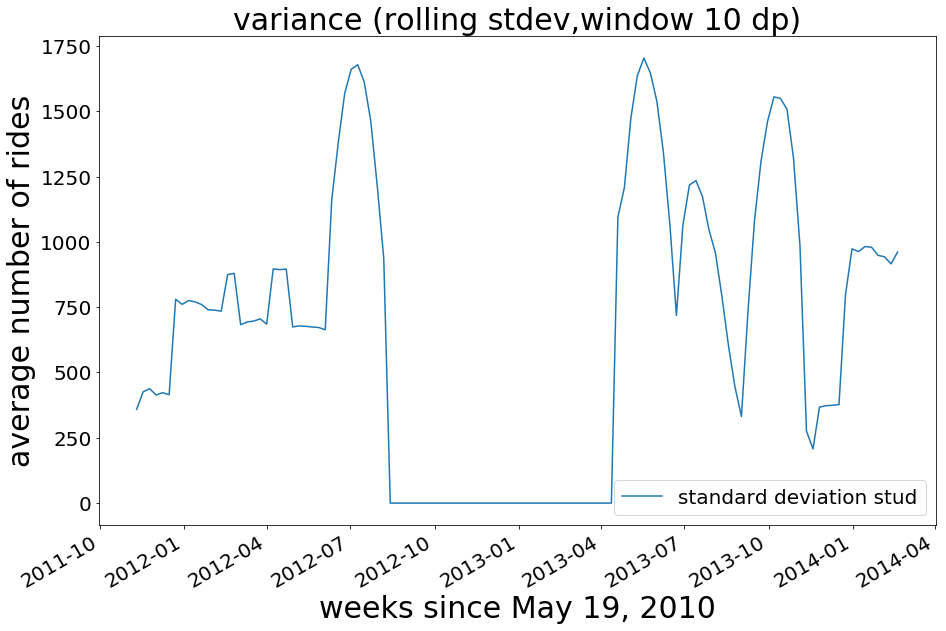

In [317]:
#rolling mean, window 10
for i in range(len(ridetype)):
    fig = pl.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.set_title("non-stationary mean (rolling mean, window 10 dp)", fontsize=30)
    ax.plot(np.arange(len(mta_ridetypes_pandas[ridetype[i]])), mta_ridetypes_pandas[ridetype[i]], label="original")
    ax.plot(np.arange(len(mta_ridetypes_pandas[ridetype[i]])), mta_ridetype_mean[ridetype[i]], label="rolling mean "+ridetype[i])
    pl.xlabel("weeks since May 19, 2010", fontsize=30)
    pl.ylabel("average number of rides", fontsize=30)
    pl.legend(fontsize=20)
    
    pl.figure()
    #ax = fig.add_subplot(111)
    mta_ridetype_std[ridetype[i]].plot(figsize=(15,10), 
                                         label="standard deviation "+ridetype[i])
    pl.title("variance (rolling stdev,window 10 dp)", fontsize=30)
    pl.xlabel("weeks since May 19, 2010", fontsize=30)
    pl.ylabel("average number of rides", fontsize=30)
    pl.legend(fontsize=20)

#rolling standard deviation, window 10
#pl.figure()
#for i in range(len(ridetype)):
    #mta_ridetype_std[ridetype[i]].plot(figsize=(15,10), 
                                         #label="standard deviation")
#ax.set_title("variance (rolling stdev,window 10 dp)", fontsize=30)
#pl.xlabel("quarters since 1959", fontsize=30)
#pl.ylabel("real GDP", fontsize=30)
#pl.legend(fontsize=20)


#### Figure 7. 

In [321]:
for i in range(len(ridetype)):
    print ("ratio of number of rides near the beginning to the number of rides near the end for type: " + ridetype[i] + 
           ": ", 
           mta_ridetype_mean[ridetype[i]].dropna().tail()[-1] / mta_ridetype_mean[ridetype[i]].dropna().head()[0])

ratio of number of rides near the beginning to the number of rides near the end for type: 10t:  1.0231917843903708
ratio of number of rides near the beginning to the number of rides near the end for type: 14d:  1.2537231244662024
ratio of number of rides near the beginning to the number of rides near the end for type: 1d:  1.1128331766118769
ratio of number of rides near the beginning to the number of rides near the end for type: 2t:  0.9350355426144698
ratio of number of rides near the beginning to the number of rides near the end for type: 30d:  1.035007607501997
ratio of number of rides near the beginning to the number of rides near the end for type: 7d:  1.3916067341041964
ratio of number of rides near the beginning to the number of rides near the end for type: ada:  0.9010338992724443
ratio of number of rides near the beginning to the number of rides near the end for type: afas:  0.00020970713136063274
ratio of number of rides near the beginning to the number of rides near the end